In [1]:
import re
import cv2
import pytesseract
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from utils import hed_util

CWD_PATH = os.getcwd()
MODEL_NAME = 'model'
HED_NAME = 'HED'
TEST_IMAGE_PATH = os.path.join(CWD_PATH, 'test_images')
HED_PROTOTEXT_PATH = os.path.join(CWD_PATH,MODEL_NAME,HED_NAME,'deploy.prototxt')
HED_CAFFEE_MODEL_PATH = os.path.join(CWD_PATH,MODEL_NAME,HED_NAME,'hed_pretrained_bsds.caffemodel')
net = hed_util.load_dnn(HED_PROTOTEXT_PATH,HED_CAFFEE_MODEL_PATH)

In [2]:
def preprocess(image, scale=1):
    #gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray,(image.shape[1]//scale,image.shape[0]//scale))
    #blur = cv2.blur(resized,(5,5))
    #thresh = cv2.threshold(resized, 100, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

    return resized

def dilate(image):
    kernel = np.ones((2,2),dtype=np.uint8)
    return cv2.dilate(image, kernel, iterations = 10)

    
#erosion
def erode(image):
    kernel = np.ones((1,1),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

def reverse_color(img):
    return cv2.bitwise_not(img)

def opening(image):
    kernel = np.ones((1, 1), np.uint8) 
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)


def getScale(image):
    height_scale = image.shape[0] // 540
    width_scale = image.shape[1] // 860
    return height_scale, width_scale

def sharpen(image):
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    return cv2.filter2D(image, -1, kernel)    

In [3]:
def drawbox(img):
    d = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
    n_boxes = len(d['text'])
    boxes = img
    for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)   
            
    plt.imshow(boxes)
    plt.show()

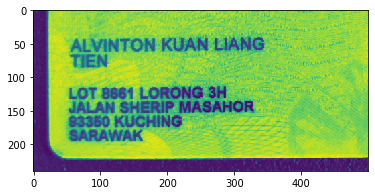

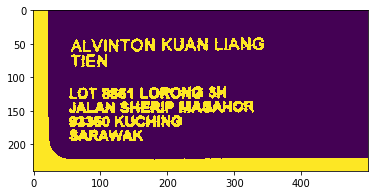

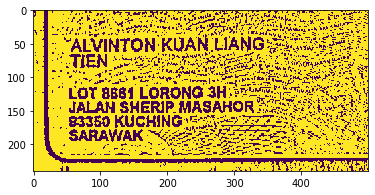

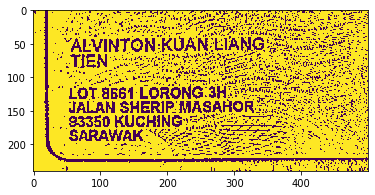

In [5]:
img_file = os.path.join(TEST_IMAGE_PATH,'ocr/myhi00123.jpg')
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
img = cv2.resize(gray,(860,540),cv2.INTER_AREA)
#cropped = img
cropped = img[300:,0:500]
#scale = 2
#cropped = cv2.resize(cropped,(image.shape[1]*scale,image.shape[0]*scale))
#cropped = cv2.medianBlur(cropped,3)
#cropped = opening(cropped)
cropped = cv2.bilateralFilter(cropped, 1, 55,55)
#cropped = cv2.GaussianBlur(cropped,(21,21),1)


#drawbox(cropped)
th1 = cv2.threshold(cropped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
th2 = cv2.adaptiveThreshold(cropped,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11, 6)
th3 = cv2.adaptiveThreshold(cropped,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11, 6)

plt.imshow(cropped)
plt.show()
plt.imshow(th1)
plt.show()
plt.imshow(th2)
plt.show()
plt.imshow(th3)

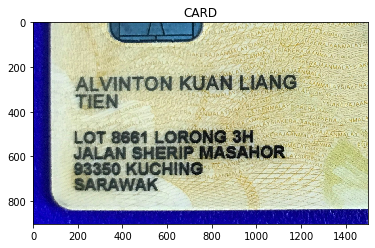

height scale  3
width scale  3


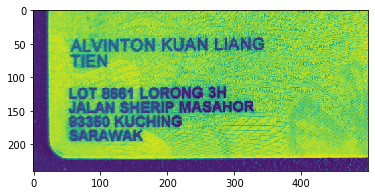

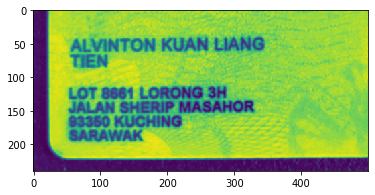

In [6]:
img_file = os.path.join(TEST_IMAGE_PATH,'ocr/myhi00123.jpg')
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
height_scale, width_scale= getScale(image)
y = 300 * height_scale
width = 500 * width_scale
card1 = image[y:,0:width]
plt.title('CARD')
plt.imshow(card1)
plt.show()
print('height scale ',height_scale)
print('width scale ',width_scale)
img = cv2.resize(gray,(860,540))
card = img[300:,0:500]
plt.imshow(card)
plt.show()
cropped = cv2.GaussianBlur(card,(5,5),0)
plt.imshow(cropped)
plt.show()


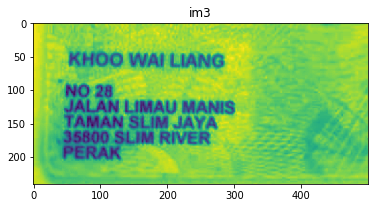

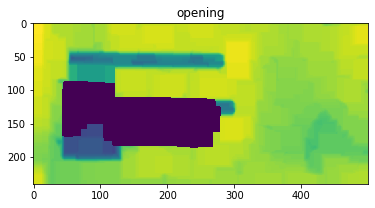

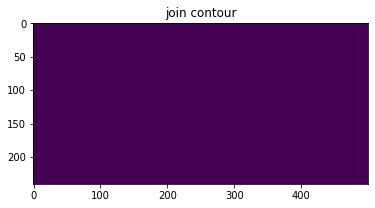

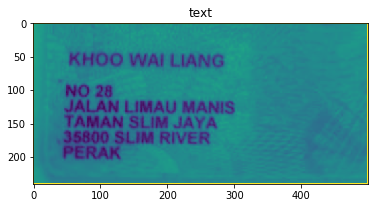

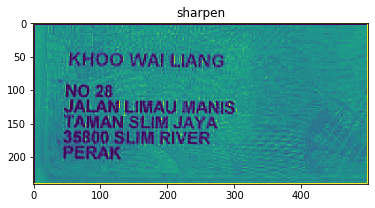

threshold value  77.0


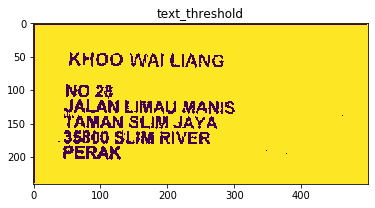

cropped:  KHOO WAI LIANG
NO 28
ALAN LIMAU MANIS
“AMAN SLIM JAYA
35800 SLIM RIVER
PERAK



In [19]:
img_file = os.path.join(TEST_IMAGE_PATH,'mxw162nmd8dkxf96q34rs3h0mqg349zrmglmhpqkkv_front.jpeg')
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
image = hed_util.crop_image(net, image)
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
#gray = cv2.equalizeHist(gray)
img = cv2.resize(gray,(860,540),cv2.INTER_AREA)
#cropped = img
card = img[300:,0:500]
#cropped = cv2.medianBlur(card,3)
cropped = cv2.bilateralFilter(card, 9, 60,60)
# Performing OTSU threshold 
#cropped = cv2.GaussianBlur(cropped,(13,13),3)
thresh1 = cv2.adaptiveThreshold(cropped,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,11, 9)
#ret, thresh1 = cv2.threshold(thresh1, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU) 
#ret, t = cv2.threshold(cropped, 150, 255, cv2.THRESH_BINARY) 

# Specify structure shape and kernel size.  
# Kernel size increases or decreases the area  
# of the rectangle to be detected. 
# A smaller value like (10, 10) will detect  
# each word instead of a sentence. 
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11)) 
  
# Appplying dilation on the threshold image 
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1) 

# Finding contours 
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,  
                                                 cv2.CHAIN_APPROX_SIMPLE) 
im2 = cropped.copy() 
im3 = card.copy()
plt.title('im3')
plt.imshow(im3)
plt.show() 
for cnt in contours: 
    x, y, w, h = cv2.boundingRect(cnt) 
    if(w>=100 and h>=20):  
        # Drawing a rectangle on copied image 
        cv2.drawContours(im2, [cnt], -1, (0,0,0), -1)
        #rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2) 

        # Cropping the text block for giving input to OCR 
        #cropped = im2[y:y + h, x:x + w] 
       
kernel = np.ones((25,25),np.uint8)
opening = cv2.morphologyEx(im2, cv2.MORPH_OPEN, kernel)
plt.title('opening')
plt.imshow(opening)
plt.show() 
#gray_op = cv2.cvtColor(opening, cv2.COLOR_BGR2GRAY)
contours_op, hierarchy_op = cv2.findContours(opening, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnt = max(contours_op, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(cnt) 
rect = cv2.rectangle(card, (x, y), (x + w, y + h), (255, 0, 0), 2) 
cv2.drawContours(im3, [cnt], -1, (0, 0, 0), -1)
#cv2.drawContours(mask, contours, idx, 255, -1) # Draw filled contour in mask
plt.title('join contour')
plt.imshow(im3)
plt.show()  
text = card[y:y+h, x:x+w]
#thresh1 = cv2.GaussianBlur(text,(3,3),0)
#text = cv2.bilateralFilter(text, 5, 50,50)
plt.title('text')
plt.imshow(text)
plt.show()
sh = sharpen(text)
plt.title('sharpen')
plt.imshow(sh)
plt.show()
threshold_value = cv2.threshold(sh, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)[0]
print('threshold value ', threshold_value)
text_threshold = cv2.threshold(sh, threshold_value-15, 255, cv2.THRESH_BINARY)[1]
plt.title('text_threshold')
plt.imshow(text_threshold)
plt.show()
custom_config = r'--oem 3 --psm 6'
print('cropped: ' ,pytesseract.image_to_string(text_threshold,config = custom_config))

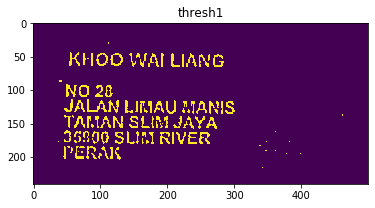

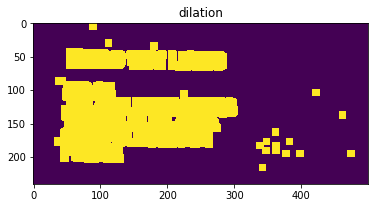

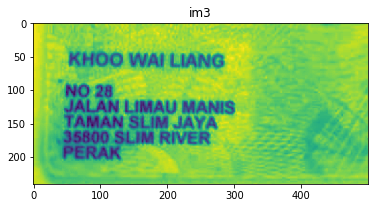

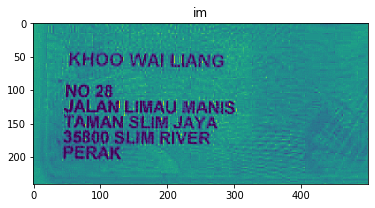

In [40]:
img_file = os.path.join(TEST_IMAGE_PATH,'mxw162nmd8dkxf96q34rs3h0mqg349zrmglmhpqkkv_front.jpeg')
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
image = hed_util.crop_image(net, image)
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
#gray = cv2.equalizeHist(gray)
img = cv2.resize(gray,(860,540),cv2.INTER_AREA)
#cropped = img
card = img[300:,0:500]
#cropped = cv2.medianBlur(card,3)
cropped = cv2.bilateralFilter(card, 9, 60,60)
# Performing OTSU threshold 
#cropped = cv2.GaussianBlur(cropped,(13,13),3)
thresh1 = cv2.adaptiveThreshold(cropped,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,11, 9)
#ret, thresh1 = cv2.threshold(thresh1, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU) 
#ret, t = cv2.threshold(cropped, 150, 255, cv2.THRESH_BINARY) 
plt.title('thresh1')
plt.imshow(thresh1)
plt.show()  
# Specify structure shape and kernel size.  
# Kernel size increases or decreases the area  
# of the rectangle to be detected. 
# A smaller value like (10, 10) will detect  
# each word instead of a sentence. 
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11)) 
  
# Appplying dilation on the threshold image 
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1) 
plt.title('dilation')
plt.imshow(dilation)
plt.show()  
# Finding contours 
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,  
                                                 cv2.CHAIN_APPROX_SIMPLE) 
im2 = cropped.copy() 
im3 = card.copy()
plt.title('im3')
plt.imshow(im3)
plt.show()  
im = sharpen(im3)
plt.title('im')
plt.imshow(im)

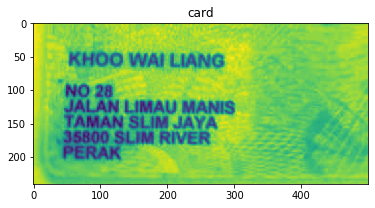

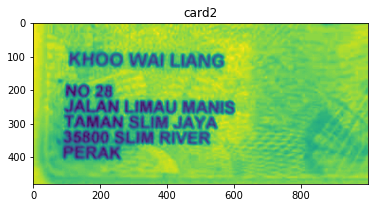

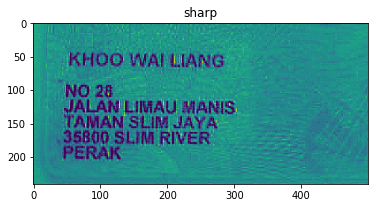

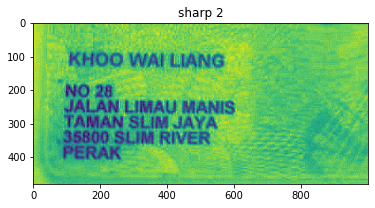

In [66]:
img_file = os.path.join(TEST_IMAGE_PATH,'mxw162nmd8dkxf96q34rs3h0mqg349zrmglmhpqkkv_front.jpeg')
image = cv2.imread(img_file, cv2.IMREAD_COLOR)
image = hed_util.crop_image(net, image)
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

img = cv2.resize(gray,(860,540),cv2.INTER_AREA)
card = img[300:,0:500]
cv2.imwrite('cropped_address.jpg',card)
plt.title('card')
plt.imshow(card)
plt.show() 
card2 = cv2.resize(card,(card.shape[1]*2,card.shape[0]*2))
plt.title('card2')
plt.imshow(card2)
plt.show() 
card = sharpen(card)
plt.title('sharp')
plt.imshow(card)
plt.show()  
card2 = sharpen(card2)
plt.title('sharp 2')
plt.imshow(card2)
plt.show()  

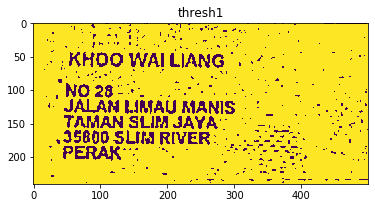

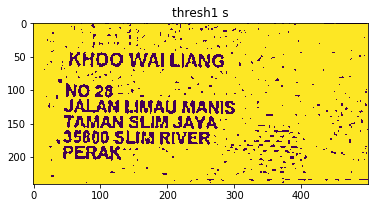

cropped:  KHOO WAI LIANG
‘NO 28
JALAN LIMAU MANIS
A SLIM JAYA
davon ive



In [80]:
#blur = cv2.bilateralFilter(card2, 9, 60, 60)
blur = cv2.medianBlur(card, 3)
thresh1 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,15, 13)
plt.title('thresh1')
plt.imshow(thresh1)
plt.show()  
thresh1 = sharpen(thresh1)
plt.title('thresh1 s')
plt.imshow(thresh1)
plt.show()  
custom_config = r'--oem 3 --psm 6'
print('cropped: ' ,pytesseract.image_to_string(card2,config = custom_config))

threshold value  88.0


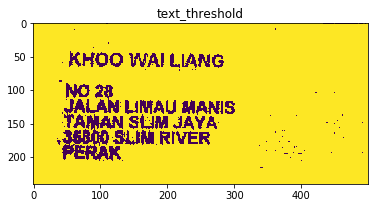

cropped:  KHOO WAI LIANG

NO 28
gALAN LIMAU MANS

TAMAN SLIM JAVA oe
SRO SLIM RIVER



In [65]:
threshold_value = cv2.threshold(card2, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)[0]
print('threshold value ', threshold_value)
text_threshold = cv2.threshold(card, threshold_value-5, 255, cv2.THRESH_BINARY)[1]
plt.title('text_threshold')
plt.imshow(text_threshold)
plt.show()
custom_config = r'--oem 3 --psm 6'
print('cropped: ' ,pytesseract.image_to_string(text_threshold,config = custom_config))